# ABC-SMC with stochastic kernel incorporating model discrepancy

In [1]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import DiscrepancyKernel
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom, plot_variables
import myokit

INFO:myokit:Loading Myokit version 1.28.3


In [3]:
import pyabc

## Initial set-up

Load experiments used for unified dataset calibration:
 - Steady-state activation [Sakakibara1992]
 - Activation time constant [Schneider1994]
 - Steady-state inactivation [Sakakibara1992]
 - Inactivation time constant (fast+slow) [Sakakibara1992]
 - Recovery time constant (fast+slow) [Sakakibara1992]

In [4]:
from experiments.ina_sakakibara import (sakakibara_inact,
                                        sakakibara_inact_kin_fast,
                                        sakakibara_rec_fast)

Load the myokit modelfile for this channel.

In [5]:
nyg_modelfile = 'models/nygren_ina.mmt' # shifted according to [Nygren1998] to match experiments
sta_modelfile = 'models/standardised_ina_nyg_act.mmt' # uses Nygren shifted activation gate

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

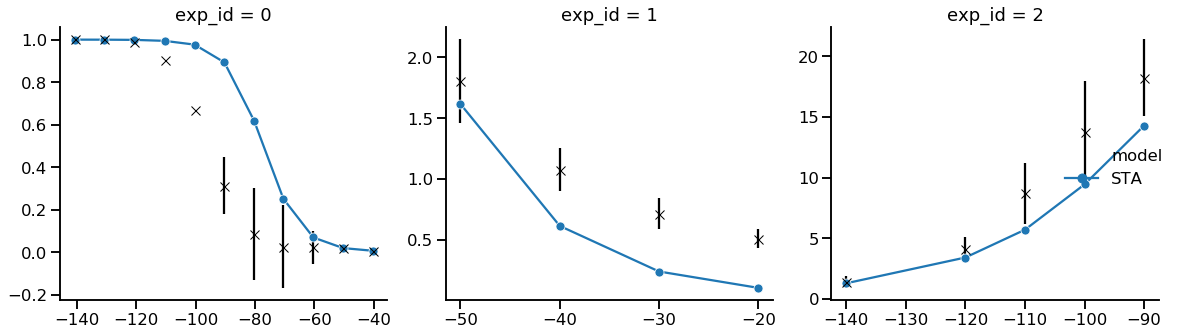

In [6]:
sns.set_context('talk')
g = plot_sim_results(sta_modelfile,
                     sakakibara_inact,
                     sakakibara_inact_kin_fast,
                     sakakibara_rec_fast)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

We assume a uniform prior in the range of the reported value.

In [7]:
limits = {'log_ina.p_5': (-7., 3.),
          'ina.p_6': (1e-7, 0.4),
          'log_ina.p_7': (-7., 3.),
          'ina.p_8': (1e-7, 0.4)}
prior_RV = {key: pyabc.RV("uniform", a, b - a)
            for key, (a,b) in limits.items()}

Add an additional parameter for the additional variance due to model discrepancy in each experiment (five total). We place a half-normal prior on each of these parameters.

In [8]:
prior_RV.update({'model_var0': pyabc.RV("uniform", 1e-7, 0.5),
                 'model_var1': pyabc.RV("uniform", 1e-7, 0.5),
                 'model_var2': pyabc.RV("uniform", 1e-7, 0.5)})
prior = pyabc.Distribution(**prior_RV)

In [9]:
observations, model, summary_statistics = setup(sta_modelfile,
                                                sakakibara_inact,
                                                sakakibara_inact_kin_fast,
                                                sakakibara_rec_fast,
                                                err_pars=['model_var0','model_var1','model_var2'])

In [10]:
# Test it all works correctly with set-up functions
assert len(observations)==len(summary_statistics(model({})))
assert len(observations) == len(summary_statistics(model(prior.rvs())))

AssertionError: 

In [11]:
keys = list(observations.index)
keys = [str(k) for k in keys]

`observations` Dataframe contains information for each experiment and variance in measurements.

In [12]:
print(observations)

           x         y  variance exp_id  normalise_factor
0  -140.6890  1.000000  0.000000      0          1.002420
1  -130.8560  0.999920  0.000000      0          1.002420
2  -120.6080  0.984181  0.000000      0          1.002420
3  -110.4540  0.902179  0.000000      0          1.002420
4  -100.3210  0.667767  0.000000      0          1.002420
5   -90.2885  0.312273  0.017769      0          1.002420
6   -80.3212  0.085694  0.046010      0          1.002420
7   -70.4131  0.025982  0.037505      0          1.002420
8   -60.3302  0.022894  0.006026      0          1.002420
9   -50.3310  0.017397  0.000000      0          1.002420
10  -40.4160  0.005877  0.000000      0          1.002420
11  -50.0000  1.000000  0.036633      1          1.802947
12  -40.0000  0.597207  0.009451      1          1.802947
13  -30.0000  0.395274  0.004883      1          1.802947
14  -20.0000  0.281418  0.001809      1          1.802947
15 -140.0000  0.076312  0.000739      2         18.227096
16 -120.0000  

In [13]:
measure_var = list(observations.variance)
exp_mask = list(observations.exp_id)

### Set-up pyABC run

In [14]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "standardised_ina_model_discrepancy.db"))

In [15]:
from ionchannelABC import theoretical_population_size
theoretical_population_size(2, len(prior_RV))

128

In [16]:
acceptor = pyabc.StochasticAcceptor()
# distance kernel uses variance from measurements and passed parameter sample of model variance
kernel = DiscrepancyKernel(keys=keys,
                           measure_var=measure_var,
                           eps_keys=['model_var0','model_var1','model_var2'],
                           exp_mask=exp_mask)
# cf [Daly2017]
n_particles = 200
eps = pyabc.Temperature(initial_temperature=1000.,
                        schemes=[pyabc.DalyScheme(alpha=0.2, min_rate=0.001)])
population_size = pyabc.ConstantPopulationSize(n_particles)
sampler = pyabc.sampler.MulticoreEvalParallelSampler(n_procs=16)
#sampler = pyabc.sampler.SingleCoreSampler() # for testing
# cf [Fillipe2007]
transition = pyabc.LocalTransition()

In [17]:
abc = pyabc.ABCSMC(model, prior, kernel,
                   summary_statistics=summary_statistics,
                   eps=eps, 
                   acceptor=acceptor,
                   sampler=sampler,
                   population_size=population_size,
                   transitions=transition)

In [18]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [19]:
history = abc.new(db_path, obs) # id=4 was attempt to calibrate all inactivation

INFO:History:Start <ABCSMC(id=1, start_time=2019-11-29 21:13:12.182846, end_time=None)>


In [20]:
history = abc.run(max_nr_populations=100)

INFO:ABC:Calibration sample before t=0.
INFO:ABC:t: 0, eps: 1000.0.
INFO:ABC:Acceptance rate: 200 / 15537 = 1.2872e-02.
INFO:ABC:t: 1, eps: 639.9999999999999.
INFO:ABC:Acceptance rate: 200 / 366 = 5.4645e-01.
INFO:ABC:t: 2, eps: 409.59999999999985.
INFO:ABC:Acceptance rate: 200 / 434 = 4.6083e-01.
INFO:ABC:t: 3, eps: 262.14399999999995.
INFO:ABC:Acceptance rate: 200 / 439 = 4.5558e-01.
INFO:ABC:t: 4, eps: 167.77215999999996.
INFO:ABC:Acceptance rate: 200 / 460 = 4.3478e-01.
INFO:ABC:t: 5, eps: 107.37418239999997.
INFO:ABC:Acceptance rate: 200 / 523 = 3.8241e-01.
INFO:ABC:t: 6, eps: 68.71947673599998.
INFO:ABC:Acceptance rate: 200 / 632 = 3.1646e-01.
INFO:ABC:t: 7, eps: 43.98046511103998.
INFO:ABC:Acceptance rate: 200 / 774 = 2.5840e-01.
INFO:ABC:t: 8, eps: 28.147497671065587.
INFO:ABC:Acceptance rate: 200 / 1123 = 1.7809e-01.
INFO:ABC:t: 9, eps: 18.014398509481975.
INFO:ABC:Acceptance rate: 200 / 1659 = 1.2055e-01.
INFO:ABC:t: 10, eps: 11.529215046068465.
INFO:ABC:Acceptance rate: 200 

### Analyse the results

In [21]:
history = pyabc.History(db_path)

In [22]:
history.all_runs()

[<ABCSMC(id=1, start_time=2019-11-29 21:13:12.182846, end_time=2019-11-30 04:53:42.077802)>]

In [23]:
df, w = history.get_distribution(m=0)

In [24]:
df.describe()

name,ina.p_6,ina.p_8,log_ina.p_5,log_ina.p_7,model_var0,model_var1,model_var2
count,200.000000,200.000000,200.000000,200.000000,2.000000e+02,200.000000,200.000000
mean,0.063411,0.089386,1.101857,-5.222743,5.335698e-04,0.046758,0.020379
std,0.004390,0.014045,0.142876,0.617653,5.609705e-04,0.049511,0.021414
min,0.053017,0.058111,0.822865,-6.870672,3.789158e-07,0.000257,0.000070
25%,0.060378,0.080821,1.000437,-5.458718,1.340842e-04,0.012050,0.004391
50%,0.062876,0.086778,1.089507,-5.097051,3.361494e-04,0.029336,0.014328
75%,0.066001,0.093953,1.181513,-4.846260,7.892464e-04,0.073118,0.027779
max,0.074395,0.127516,1.628006,-3.786425,3.555428e-03,0.257585,0.130707


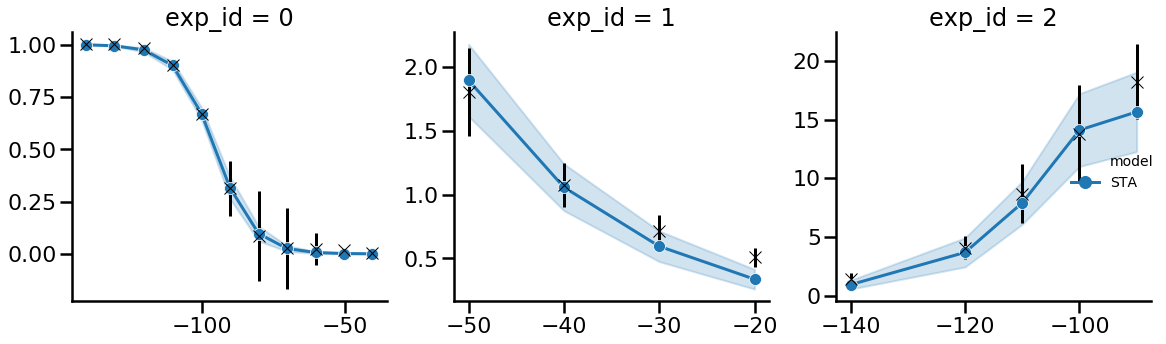

In [25]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(sta_modelfile,
                     sakakibara_inact,
                     sakakibara_inact_kin_fast,
                     sakakibara_rec_fast,
                     df=df[list(limits.keys())], w=w)

plt.tight_layout()

In [26]:
# Voltage range to plot gating functions over
v = np.arange(-140, 50, 0.5)

# Mapping an id to the parameter name in the mmt modelfile
sta_par_map = {'mi': 'ina.m_ss',
               'mt': 'ina.tau_m',
               'hi': 'ina.h_ss',
               'ht': 'ina.tau_h1',
               'ji': 'ina.h_ss',
               'jt': 'ina.tau_h2'}

In [27]:
N = 100
sta_par_samples = df[list(limits.keys())].sample(n=N, weights=w, replace=True)
sta_par_samples = sta_par_samples.set_index([pd.Index(range(N))])
sta_par_samples = sta_par_samples.to_dict(orient='records')

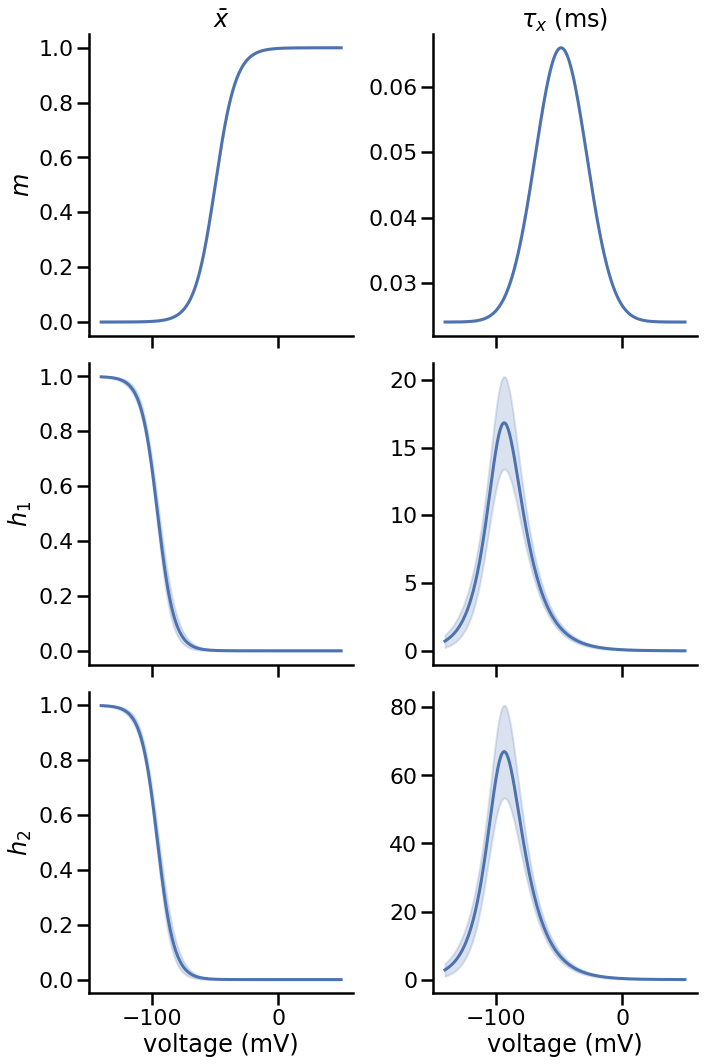

In [28]:
sns.set_context("poster")
sns.set_palette("deep")

mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14

f, ax = plot_variables(v, 
                       sta_par_map, 
                       sta_modelfile,
                       [sta_par_samples],
                       original=False,
                       figshape=(2,3))

ax[0][0].set_ylabel(r'$m$')
ax[1][0].set_ylabel(r'$h_1$')
ax[2][0].set_ylabel(r'$h_2$')
ax[0][0].set_title(r'$\bar{x}$')
ax[0][1].set_title(r'$\tau_x$ (ms)')
for a in ax[:,1].flatten():
    a.set_ylabel('')    
for a in ax[2][:]:
    a.set_xlabel('voltage (mV)')
    
plt.tight_layout()

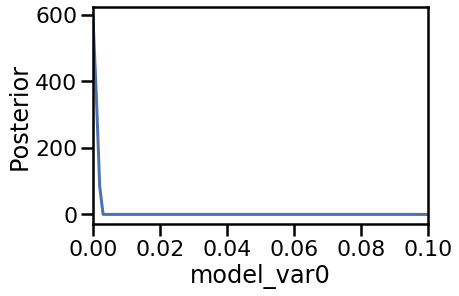

In [34]:
_, ax = plt.subplots()
pyabc.visualization.plot_kde_1d_highlevel(
    history, x='model_var0',
    xmin=0, xmax=0.1, numx=100, ax=ax)  

In [29]:
from ionchannelABC.visualization import plot_experiment_traces

In [30]:
def split_inact(data):
    out = []
    for d in data.split_periodic(11030, adjust=True):
        d = d.trim_left(10950, adjust=True)
        out.append(d)
    return out

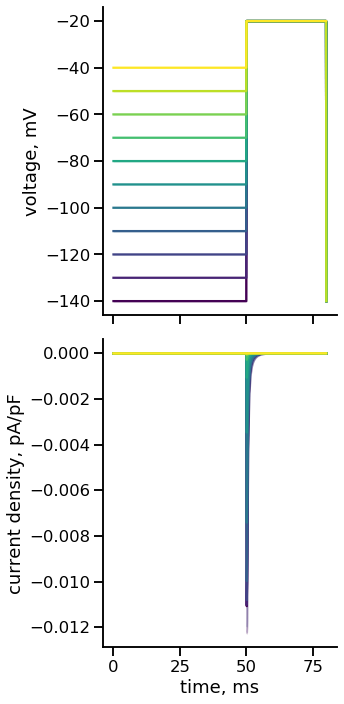

In [32]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_experiment_traces(sta_modelfile, 'ina.i_Na', [split_inact],
                           sakakibara_inact,
                           df=df[list(limits.keys())], w=w, 
                           log_interval=0.1)

xlabel = "time, ms"
ylabels = ["voltage, mV", "current density, pA/pF"]
for ax in g.axes[1,:]:
    ax.set_xlabel(xlabel)
for ax, yl in zip(g.axes, ylabels):
    ax[0].set_ylabel(yl)
for ax in g.axes.flatten():
    ax.set_title('')
    
plt.tight_layout()

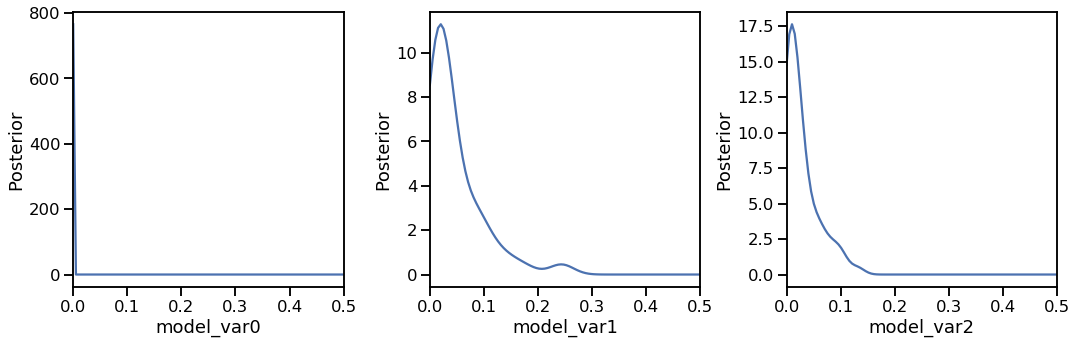

In [33]:
_, ax = plt.subplots(ncols=3, figsize=(15,5))
for i, a in enumerate(ax):
    pyabc.visualization.plot_kde_1d_highlevel(
        history, x=f"model_var{i}",
        xmin=0., xmax=0.5, numx=100, ax=a)
plt.tight_layout()